# Product Description Generation

## Install Packages

In [4]:
import sys
!{sys.executable} -m pip install -r requirements.txt

  Using cached matplotlib-3.3.2-cp38-cp38-manylinux1_x86_64.whl (11.6 MB)
  Using cached certifi-2020.6.20-py2.py3-none-any.whl (156 kB)
  Using cached cycler-0.10.0-py2.py3-none-any.whl (6.5 kB)
  Using cached kiwisolver-1.2.0-cp38-cp38-manylinux1_x86_64.whl (92 kB)


## Initialization
### Import Statements

In [5]:
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
from torch.autograd import Variable

### System Variables

In [6]:
matplotlib_is_available = True
try:
  from matplotlib import pyplot as plt
except ImportError:
  print("Will skip plotting; matplotlib is not available.")
  matplotlib_is_available = False

# Data params
data_mean = 4
data_stddev = 1.25

### Choose Setting

In [7]:
# ### Uncomment only one of these to define what data is actually sent to the Discriminator
#(name, preprocess, d_input_func) = ("Raw data", lambda data: data, lambda x: x)
#(name, preprocess, d_input_func) = ("Data and variances", lambda data: decorate_with_diffs(data, 2.0), lambda x: x * 2)
#(name, preprocess, d_input_func) = ("Data and diffs", lambda data: decorate_with_diffs(data, 1.0), lambda x: x * 2)
(name, preprocess, d_input_func) = ("Only 4 moments", lambda data: get_moments(data), lambda x: 4)

print("Using data [%s]" % (name))

Using data [Only 4 moments]


## Data

In [8]:
def get_distribution_sampler(mu, sigma):
    return lambda n: torch.Tensor(np.random.normal(mu, sigma, (1, n)))  # Gaussian

def get_generator_input_sampler():
    return lambda m, n: torch.rand(m, n)  # Uniform-dist data into generator, _NOT_ Gaussian

## Models

In [10]:
class Generator(nn.Module):
    def __init__(self, input_size, hidden_size, output_size, f):
        super(Generator, self).__init__()
        self.map1 = nn.Linear(input_size, hidden_size)
        self.map2 = nn.Linear(hidden_size, hidden_size)
        self.map3 = nn.Linear(hidden_size, output_size)
        self.f = f

    def forward(self, x):
        x = self.map1(x)
        x = self.f(x)
        x = self.map2(x)
        x = self.f(x)
        x = self.map3(x)
        return x

class Discriminator(nn.Module):
    def __init__(self, input_size, hidden_size, output_size, f):
        super(Discriminator, self).__init__()
        self.map1 = nn.Linear(input_size, hidden_size)
        self.map2 = nn.Linear(hidden_size, hidden_size)
        self.map3 = nn.Linear(hidden_size, output_size)
        self.f = f

    def forward(self, x):
        x = self.f(self.map1(x))
        x = self.f(self.map2(x))
        return self.f(self.map3(x))
    
def extract(v):
    return v.data.storage().tolist()

def stats(d):
    return [np.mean(d), np.std(d)]

def get_moments(d):
    # Return the first 4 moments of the data provided
    mean = torch.mean(d)
    diffs = d - mean
    var = torch.mean(torch.pow(diffs, 2.0))
    std = torch.pow(var, 0.5)
    zscores = diffs / std
    skews = torch.mean(torch.pow(zscores, 3.0))
    kurtoses = torch.mean(torch.pow(zscores, 4.0)) - 3.0  # excess kurtosis, should be 0 for Gaussian
    final = torch.cat((mean.reshape(1,), std.reshape(1,), skews.reshape(1,), kurtoses.reshape(1,)))
    return final

def decorate_with_diffs(data, exponent, remove_raw_data=False):
    mean = torch.mean(data.data, 1, keepdim=True)
    mean_broadcast = torch.mul(torch.ones(data.size()), mean.tolist()[0][0])
    diffs = torch.pow(data - Variable(mean_broadcast), exponent)
    if remove_raw_data:
        return torch.cat([diffs], 1)
    else:
        return torch.cat([data, diffs], 1)

## Train

In [11]:
def train():
    # Model parameters
    g_input_size = 1      # Random noise dimension coming into generator, per output vector
    g_hidden_size = 5     # Generator complexity
    g_output_size = 1     # Size of generated output vector
    d_input_size = 500    # Minibatch size - cardinality of distributions
    d_hidden_size = 10    # Discriminator complexity
    d_output_size = 1     # Single dimension for 'real' vs. 'fake' classification
    minibatch_size = d_input_size

    d_learning_rate = 1e-3
    g_learning_rate = 1e-3
    sgd_momentum = 0.9

    num_epochs = 5000
    print_interval = 100
    d_steps = 20
    g_steps = 20

    dfe, dre, ge = 0, 0, 0
    d_real_data, d_fake_data, g_fake_data = None, None, None

    discriminator_activation_function = torch.sigmoid
    generator_activation_function = torch.tanh

    d_sampler = get_distribution_sampler(data_mean, data_stddev)
    gi_sampler = get_generator_input_sampler()
    G = Generator(input_size=g_input_size,
                  hidden_size=g_hidden_size,
                  output_size=g_output_size,
                  f=generator_activation_function)
    D = Discriminator(input_size=d_input_func(d_input_size),
                      hidden_size=d_hidden_size,
                      output_size=d_output_size,
                      f=discriminator_activation_function)
    criterion = nn.BCELoss()  # Binary cross entropy: http://pytorch.org/docs/nn.html#bceloss
    d_optimizer = optim.SGD(D.parameters(), lr=d_learning_rate, momentum=sgd_momentum)
    g_optimizer = optim.SGD(G.parameters(), lr=g_learning_rate, momentum=sgd_momentum)

    for epoch in range(num_epochs):
        for d_index in range(d_steps):
            # 1. Train D on real+fake
            D.zero_grad()

            #  1A: Train D on real
            d_real_data = Variable(d_sampler(d_input_size))
            d_real_decision = D(preprocess(d_real_data))
            d_real_error = criterion(d_real_decision, Variable(torch.ones([1,1])))  # ones = true
            d_real_error.backward() # compute/store gradients, but don't change params

            #  1B: Train D on fake
            d_gen_input = Variable(gi_sampler(minibatch_size, g_input_size))
            d_fake_data = G(d_gen_input).detach()  # detach to avoid training G on these labels
            d_fake_decision = D(preprocess(d_fake_data.t()))
            d_fake_error = criterion(d_fake_decision, Variable(torch.zeros([1,1])))  # zeros = fake
            d_fake_error.backward()
            d_optimizer.step()     # Only optimizes D's parameters; changes based on stored gradients from backward()

            dre, dfe = extract(d_real_error)[0], extract(d_fake_error)[0]

        for g_index in range(g_steps):
            # 2. Train G on D's response (but DO NOT train D on these labels)
            G.zero_grad()

            gen_input = Variable(gi_sampler(minibatch_size, g_input_size))
            g_fake_data = G(gen_input)
            dg_fake_decision = D(preprocess(g_fake_data.t()))
            g_error = criterion(dg_fake_decision, Variable(torch.ones([1,1])))  # Train G to pretend it's genuine

            g_error.backward()
            g_optimizer.step()  # Only optimizes G's parameters
            ge = extract(g_error)[0]

        if epoch % print_interval == 0:
            print("Epoch %s: D (%s real_err, %s fake_err) G (%s err); Real Dist (%s),  Fake Dist (%s) " %
                  (epoch, dre, dfe, ge, stats(extract(d_real_data)), stats(extract(d_fake_data))))

    if matplotlib_is_available:
        print("Plotting the generated distribution...")
        values = extract(g_fake_data)
        print(" Values: %s" % (str(values)))
        plt.hist(values, bins=50)
        plt.xlabel('Value')
        plt.ylabel('Count')
        plt.title('Histogram of Generated Distribution')
        plt.grid(True)
        plt.show()

/home/leonard/Workspace/ai/gan-example/gan-example-env/lib/python3.8/site-packages/torch/nn/modules/loss.py:516: UserWarning: Using a target size (torch.Size([1, 1])) that is different to the input size (torch.Size([1])) is deprecated. Please ensure they have the same size.
  return F.binary_cross_entropy(input, target, weight=self.weight, reduction=self.reduction)


Epoch 0: D (0.6356237530708313 real_err, 0.7457542419433594 fake_err) G (0.6436469554901123 err); Real Dist ([4.097293556138873, 1.3608997742610422]),  Fake Dist ([-0.26511934959888456, 0.00287179412706117]) 
Epoch 100: D (0.38277196884155273 real_err, 0.38550567626953125 fake_err) G (1.1090707778930664 err); Real Dist ([4.012139488995075, 1.2652739553653076]),  Fake Dist ([6.3833117618560795, 0.024387508731657303]) 
Epoch 200: D (0.804203450679779 real_err, 0.651988685131073 fake_err) G (0.6777949929237366 err); Real Dist ([3.9327941635251045, 1.2453464088484818]),  Fake Dist ([5.797787687182426, 2.373885405064121]) 
Epoch 300: D (0.7125104665756226 real_err, 0.6992738246917725 fake_err) G (0.6834885478019714 err); Real Dist ([3.9833833258748053, 1.2628161802604523]),  Fake Dist ([3.7294673819541933, 1.9896248352751682]) 
Epoch 400: D (0.6950849294662476 real_err, 0.6967185139656067 fake_err) G (0.6893845200538635 err); Real Dist ([4.008415797114372, 1.2440061054313922]),  Fake Dist (

Epoch 4000: D (0.6935822367668152 real_err, 0.6935535073280334 fake_err) G (0.6927391886711121 err); Real Dist ([3.9427191668748858, 1.2390430581914194]),  Fake Dist ([6.8668814554214475, 0.6402766202510479]) 
Epoch 4100: D (0.6934506297111511 real_err, 0.6935425400733948 fake_err) G (0.6927523016929626 err); Real Dist ([3.9318987146615982, 1.279211874193192]),  Fake Dist ([6.904089312553406, 0.6705021695637622]) 
Epoch 4200: D (0.693457305431366 real_err, 0.6935186982154846 fake_err) G (0.6927786469459534 err); Real Dist ([3.9807126039266585, 1.2844967712273354]),  Fake Dist ([6.962624062538147, 0.7017590818787743]) 
Epoch 4300: D (0.6934190988540649 real_err, 0.6935052275657654 fake_err) G (0.6927909255027771 err); Real Dist ([3.9319404734373093, 1.298327987966256]),  Fake Dist ([6.953814260482788, 0.6720651623256297]) 
Epoch 4400: D (0.6933931708335876 real_err, 0.6934933066368103 fake_err) G (0.6927995085716248 err); Real Dist ([3.9570751308202743, 1.323941686140453]),  Fake Dist (

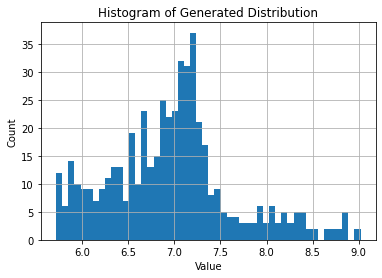

In [12]:
train()